# Assignment 4: Hamiltonian Learning of Spin-1/2 Chains
This code implements a test of the robusness of our training models.

## Imports

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pickle
import torch
import torch.nn as nn
import functools
import scipy.linalg

## Definiciones

In [ ]:
def kron(args):
    """
    Kronecker product with variable-length arguments.
    """
    backend = np if isinstance(args[0], np.ndarray) else __import__("torch")
    return functools.reduce(backend.kron, args)



# ============================================================
# 0) Pauli matrices y bases de medida
# ============================================================
def paulis():
    I = np.eye(2, dtype=np.complex128)
    X = np.array([[0, 1], [1, 0]], dtype=np.complex128)
    Y = np.array([[0, -1j], [1j, 0]], dtype=np.complex128)
    Z = np.array([[1, 0], [0, -1]], dtype=np.complex128)
    return I, X, Y, Z


def single_qubit_measurement_unitary(axis: int) -> np.ndarray:
    """
    Unitaria que rota la base de medida al eje deseado.
    axis: 0->X, 1->Y, 2->Z
    - Si medimos en X: aplicamos H (Hadamard) y luego medimos en computacional.
    - Si medimos en Y: aplicamos S^† H y luego medimos en computacional.
    - Si medimos en Z: identidad.
    """
    H = np.array([[1, 1], [1, -1]], dtype=np.complex128) / np.sqrt(2)
    Sdg = np.array([[1, 0], [0, -1j]], dtype=np.complex128)  # S^\dagger

    if axis == 0:      # X
        return H
    elif axis == 1:    # Y
        return Sdg @ H
    elif axis == 2:    # Z
        return np.eye(2, dtype=np.complex128)
    else:
        raise ValueError("axis must be 0 (X), 1 (Y), or 2 (Z)")


def rotate_state_for_pauli_measurement(state: np.ndarray, pauli_obs: np.ndarray) -> np.ndarray:
    """
    Aplica U = ⊗_i U_i(pauli_obs[i]) al estado (vector) para convertir
    medición en {X,Y,Z}^n en una medición en la base computacional.

    state: vector (2^n,)
    pauli_obs: array shape (n,), entries in {0,1,2} for X,Y,Z
    """
    n = pauli_obs.shape[0]
   
    U_factors = [single_qubit_measurement_unitary(int(a)) for a in pauli_obs]
    U = kron(U_factors)  
    return U @ state



In [ ]:
# ============================================================
# 1) Apartado 1 (mínimo): elegir Hamiltoniano (Transverse Ising)
#    H = a * sum_i X_i X_{i+1} + b * sum_i Z_i
# ============================================================
def build_richer_hamiltonian_dense(n: int, params: dict) -> np.ndarray:
    """
    Hamiltoniano más complejo (opción 1: más términos):
      H = sum_i [Jxx X_iX_{i+1} + Jyy Y_iY_{i+1} + Jzz Z_iZ_{i+1}]
        + sum_i [hx X_i + hz Z_i]

    params debe contener: {"Jxx","Jyy","Jzz","hx","hz"}
    """
    I, X, Y, Z = paulis()
    dim = 2**n
    H = np.zeros((dim, dim), dtype=np.complex128)

    Jxx = params["Jxx"]
    Jyy = params["Jyy"]
    Jzz = params["Jzz"]
    hx  = params["hx"]
    hz  = params["hz"]

    # Interacciones de vecinos
    for i in range(n - 1):
        ops = [I] * n
        ops[i] = X; ops[i + 1] = X
        H += Jxx * kron(ops)

        ops = [I] * n
        ops[i] = Y; ops[i + 1] = Y
        H += Jyy * kron(ops)

        ops = [I] * n
        ops[i] = Z; ops[i + 1] = Z
        H += Jzz * kron(ops)

    # Campos locales
    for i in range(n):
        ops = [I] * n
        ops[i] = X
        H += hx * kron(ops)

        ops = [I] * n
        ops[i] = Z
        H += hz * kron(ops)

    # Hermiticidad defensiva
    H = 0.5 * (H + H.conj().T)
    return H



# ============================================================
# 2) Apartado 2: generar dataset tipo Algorithm 9
#    - estados iniciales fáciles
#    - tiempos
#    - observables Pauli aleatorios
#    - muestreo (shots) tras rotación a base computacional
# ============================================================
def basis_state(n: int, index: int) -> np.ndarray:
    """|index> en base computacional, como vector (2^n,)."""
    v = np.zeros(2**n, dtype=np.complex128)
    v[index] = 1.0
    return v


def plus_state(n: int) -> np.ndarray:
    """|+>^{⊗n}"""
    v_plus = np.array([1.0, 1.0], dtype=np.complex128) / np.sqrt(2)
    return kron([v_plus] * n)  


def random_product_state(n: int, rng: np.random.Generator) -> np.ndarray:
    """
    Estado producto aleatorio: ⊗_i (cos(theta/2)|0> + e^{i phi} sin(theta/2)|1>)
    """
    vecs = []
    for _ in range(n):
        theta = rng.uniform(0.0, np.pi)
        phi = rng.uniform(0.0, 2 * np.pi)
        v = np.array([np.cos(theta / 2), np.exp(1j * phi) * np.sin(theta / 2)], dtype=np.complex128)
        v = v / np.linalg.norm(v)
        vecs.append(v)
    return kron(vecs)  


def evolve_state_exact(H: np.ndarray, psi0: np.ndarray, t: float) -> np.ndarray:
    """
    Evolución exacta: psi(t) = exp(-i H t) psi0
    """
    U = scipy.linalg.expm(-1j * t * H)
    psi_t = U @ psi0
    # normalización defensiva
    psi_t = psi_t / np.linalg.norm(psi_t)
    return psi_t


def sample_measurements_in_pauli_basis(
    psi_t: np.ndarray,
    pauli_obs: np.ndarray,
    shots: int,
    rng: np.random.Generator
) -> np.ndarray:
    """
    Simula mediciones: rota el estado para medir en la base Pauli dada
    y luego muestrea índices de la base computacional según |amp|^2.

    Devuelve: array shape (shots,) con enteros en [0, 2^n - 1]
    """
    psi_rot = rotate_state_for_pauli_measurement(psi_t, pauli_obs)
    probs = np.abs(psi_rot) ** 2
    probs = probs / probs.sum()
    samples = rng.choice(np.arange(probs.shape[0]), size=shots, p=probs).astype(np.int64)
    return samples


def generate_dataset_algorithm9_style(
    n: int,
    true_params: dict,
    num_initial_states: int = 3,
    num_times: int = 20,
    dt: float = 0.2,
    num_paulis: int = 30,
    shots: int = 200,
    seed: int = 0,
):
    """
    Genera dataset estilo Algorithm 9:
      - initial_states: lista de estados iniciales (vectores)
      - times: array (num_times,)
      - pauli_obs: array (num_paulis, n) con entries 0/1/2 (X/Y/Z)
      - samples: array (S, T, P, shots) con índices en base computacional

    true_params: dict con claves necesarias para construir H.
      Para Transverse Ising: {"a":..., "b":...}
    """
    rng = np.random.default_rng(seed)

    H_true = build_richer_hamiltonian_dense(n=n, params=true_params)

    # --- Estados iniciales (fáciles)
    initial_states = []
    if num_initial_states >= 1:
        initial_states.append(basis_state(n, 0))      # |0...0>
    if num_initial_states >= 2:
        initial_states.append(plus_state(n))          # |+...+>
    while len(initial_states) < num_initial_states:
        initial_states.append(random_product_state(n, rng))

    initial_states = np.stack(initial_states, axis=0)  # (S, 2^n)

    # --- Tiempos
    times = dt * (np.arange(1, num_times + 1))  # (T,)

    # --- Observables Pauli locales aleatorios: 0(X),1(Y),2(Z)
    pauli_obs = rng.integers(0, 3, size=(num_paulis, n), endpoint=False)

    # --- Muestreo
    # samples shape: (S, T, P, shots)
    S = initial_states.shape[0]
    samples = np.empty((S, num_times, num_paulis, shots), dtype=np.int64)

    for s in range(S):
        psi0 = initial_states[s]
        for ti, t in enumerate(times):
            psi_t = evolve_state_exact(H_true, psi0, float(t))
            for p in range(num_paulis):
                samples[s, ti, p, :] = sample_measurements_in_pauli_basis(
                    psi_t=psi_t,
                    pauli_obs=pauli_obs[p],
                    shots=shots,
                    rng=rng
                )

    dataset = {
        "n": n,
        "true_params": true_params,
        "initial_states": initial_states,
        "times": times,
        "pauli_obs": pauli_obs,
        "samples": samples,
    }
    return dataset


def save_dataset_npz(dataset: dict, filename: str = "dataset_part2_algorithm9.npz"):
    """Guardar dataset en NPZ."""
    np.savez_compressed(
        filename,
        n=dataset["n"],
        true_params=str(dataset["true_params"]),
        initial_states=dataset["initial_states"],
        times=dataset["times"],
        pauli_obs=dataset["pauli_obs"],
        samples=dataset["samples"],
    )



## Dataset

In [3]:
n = 4  # número de qubits

true_params = {"Jxx": 0.1, "Jyy": 0.2, "Jzz": 0.7, "hx": 0.3, "hz": 1}
dataset = generate_dataset_algorithm9_style(
    n=n,
    true_params=true_params,
    num_initial_states=3,
    num_times=20,   # recomendado (antes 20)
    dt=0.2,
    num_paulis=30,  # recomendado (antes 30)
    shots=200,      # recomendado (antes 200)
    seed=42,
)

print("initial_states:", dataset["initial_states"].shape)  # (S, 2^n)
print("times:", dataset["times"].shape)                    # (T,)
print("pauli_obs:", dataset["pauli_obs"].shape)            # (P, n)
print("samples:", dataset["samples"].shape)                # (S, T, P, shots)
print("true_params:", dataset["true_params"])

save_dataset_npz(dataset, "dataset_part2_algorithm9_richer.npz")
print("Saved -> dataset_part2_algorithm9_richer.npz")

# ------------------------------------------------------------
# Print dataset "head" (sanity check)
# ------------------------------------------------------------
print("\n=== DATASET HEAD ===")
print("\nInitial state [0] (first 5 amplitudes):")
print(dataset["initial_states"][0][:5])

print("\nTimes (first 5):")
print(dataset["times"][:5])

print("\nPauli observable [0] (0=X, 1=Y, 2=Z):")
print(dataset["pauli_obs"][0])

print("\nSamples [state=0, time=0, pauli=0] (first 10 shots):")
print(dataset["samples"][0, 0, 0, :10])
print("Cada número es un resultado de medición, es decir, un bitstring medido.")
print("Ejemplo: 5 -> '00000101' en binario, lo que significa que se midió |0> en qubits 0,2 y |1> en qubits 1,3,...")


initial_states: (3, 16)
times: (20,)
pauli_obs: (30, 4)
samples: (3, 20, 30, 200)
true_params: {'Jxx': 0.1, 'Jyy': 0.2, 'Jzz': 0.7, 'hx': 0.3, 'hz': 1}
Saved -> dataset_part2_algorithm9_richer.npz

=== DATASET HEAD ===

Initial state [0] (first 5 amplitudes):
[1.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j]

Times (first 5):
[0.2 0.4 0.6 0.8 1. ]

Pauli observable [0] (0=X, 1=Y, 2=Z):
[1 0 2 1]

Samples [state=0, time=0, pauli=0] (first 10 shots):
[ 0  5  1  5 12  1  0  4  4  9]
Cada número es un resultado de medición, es decir, un bitstring medido.
Ejemplo: 5 -> '00000101' en binario, lo que significa que se midió |0> en qubits 0,2 y |1> en qubits 1,3,...


## Hamiltoniano

In [ ]:
# ============================================================
# Assignment 4 — Apartado 3
# Ansatz Hamiltonian: Transverse Ising
#
# H_A(c) = c_xx * sum_i X_i X_{i+1} + c_z * sum_i Z_i
# ============================================================

def build_ansatz_hamiltonian_torch(n: int, params: torch.Tensor, device="cpu") -> torch.Tensor:
    """
    H_A =
      Jxx * sum_i X_i X_{i+1}
    + Jyy * sum_i Y_i Y_{i+1}
    + Jzz * sum_i Z_i Z_{i+1}
    + hx  * sum_i X_i
    + hz  * sum_i Z_i

    params: tensor shape (5,) real/complex with zero imaginary part
            [Jxx, Jyy, Jzz, hx, hz]
    """
    Jxx = params[0]
    Jyy = params[1]
    Jzz = params[2]
    hx  = params[3]
    hz  = params[4]

    I, X, Y, Z = paulis_torch(device=device)
    dim = 2**n
    H = torch.zeros((dim, dim), dtype=torch.complex128, device=device)

    # Nearest-neighbour interactions
    for i in range(n - 1):
        ops = [I] * n
        ops[i] = X; ops[i + 1] = X
        H = H + Jxx * kron(ops)

        ops = [I] * n
        ops[i] = Y; ops[i + 1] = Y
        H = H + Jyy * kron(ops)

        ops = [I] * n
        ops[i] = Z; ops[i + 1] = Z
        H = H + Jzz * kron(ops)

    # Local fields
    for i in range(n):
        ops = [I] * n
        ops[i] = X
        H = H + hx * kron(ops)

        ops = [I] * n
        ops[i] = Z
        H = H + hz * kron(ops)

    H = 0.5 * (H + H.conj().T)
    return H

# ============================================================
# Assignment 4 — Apartado 4
# Train a VANILLA Hamiltonian model + visualise results
#
# Vanilla model:
#  - Ansatz Hamiltonian H_A(c) = c_xx * sum_i X_i X_{i+1} + c_z * sum_i Z_i
#  - Exact unitary evolution U(t) = exp(-i H_A t) via eigendecomposition
#  - Likelihood training on Algorithm-9-style measurement samples
#
# We assume you already generated a dataset dict like:
#   dataset = {
#      "n": n,
#      "true_params": {"a":..., "b":...},
#      "initial_states": (S, 2^n) complex numpy,
#      "times": (T,) float numpy,
#      "pauli_obs": (P, n) int numpy with entries 0/1/2 for X/Y/Z,
#      "samples": (S, T, P, shots) int numpy in [0,2^n-1]
#   }
#
# ============================================================

def kron(args):
    """
    Kronecker product with variable-length arguments.
    """
    backend = np if isinstance(args[0], np.ndarray) else torch
    return functools.reduce(backend.kron, args)


# ============================================================
# 1) Pauli matrices (torch) + rotaciones de medida
# ============================================================
def paulis_torch(device="cpu"):
    I = torch.eye(2, dtype=torch.complex128, device=device)
    X = torch.tensor([[0, 1], [1, 0]], dtype=torch.complex128, device=device)
    Y = torch.tensor([[0, -1j], [1j, 0]], dtype=torch.complex128, device=device)
    Z = torch.tensor([[1, 0], [0, -1]], dtype=torch.complex128, device=device)
    return I, X, Y, Z


def single_qubit_measurement_unitary_torch(axis: int, device="cpu") -> torch.Tensor:
    """
    U(axis) rota la base para medir en X/Y/Z mediante medición en computacional.
      axis: 0->X, 1->Y, 2->Z.
    """
    H = torch.tensor([[1, 1], [1, -1]], dtype=torch.complex128, device=device) / np.sqrt(2)
    Sdg = torch.tensor([[1, 0], [0, -1j]], dtype=torch.complex128, device=device)

    if axis == 0:
        return H
    elif axis == 1:
        return Sdg @ H
    elif axis == 2:
        return torch.eye(2, dtype=torch.complex128, device=device)
    else:
        raise ValueError("axis must be 0 (X), 1 (Y), or 2 (Z)")


def build_rotation_operator(pauli_obs_row: np.ndarray, device="cpu") -> torch.Tensor:
    """
    Construye U = ⊗_i U_i(pauli_obs[i]) como matriz (2^n, 2^n).
    pauli_obs_row: shape (n,) int in {0,1,2}
    """
    factors = [single_qubit_measurement_unitary_torch(int(a), device=device) for a in pauli_obs_row]
    return kron(factors) 


# ============================================================
# 2) Ansatz Hamiltonian (torch, diferenciable)
# ============================================================
def build_ansatz_hamiltonian_torch(n: int, params: torch.Tensor, device="cpu") -> torch.Tensor:
    """
    Hamiltoniano ansatz más complejo (5 parámetros):
      H =
        Jxx * sum_i X_i X_{i+1}
      + Jyy * sum_i Y_i Y_{i+1}
      + Jzz * sum_i Z_i Z_{i+1}
      + hx  * sum_i X_i
      + hz  * sum_i Z_i

    params: tensor shape (5,) = [Jxx, Jyy, Jzz, hx, hz]
    """
    Jxx = params[0]
    Jyy = params[1]
    Jzz = params[2]
    hx  = params[3]
    hz  = params[4]

    I, X, Y, Z = paulis_torch(device=device)
    dim = 2**n
    H = torch.zeros((dim, dim), dtype=torch.complex128, device=device)

    # Interacciones vecino a vecino
    for i in range(n - 1):
        ops = [I] * n
        ops[i] = X; ops[i + 1] = X
        H = H + Jxx * kron(ops)

        ops = [I] * n
        ops[i] = Y; ops[i + 1] = Y
        H = H + Jyy * kron(ops)

        ops = [I] * n
        ops[i] = Z; ops[i + 1] = Z
        H = H + Jzz * kron(ops)

    # Campos locales
    for i in range(n):
        ops = [I] * n
        ops[i] = X
        H = H + hx * kron(ops)

        ops = [I] * n
        ops[i] = Z
        H = H + hz * kron(ops)

    H = 0.5 * (H + H.conj().T)
    return H

# ============================================================
# 3) Evolución exacta U(t) psi0 usando eigh (estable + autodiff)
# ============================================================
def evolve_state_matrix_exp(H: torch.Tensor, psi0: torch.Tensor, t: float) -> torch.Tensor:
    """
    psi(t) = exp(-i H t) psi0
    usando exponencial matricial (gradiente bien definido).
    """
    U = torch.matrix_exp((-1j * t) * H)
    psi_t = U @ psi0
    psi_t = psi_t / torch.linalg.norm(psi_t)
    return psi_t

# ============================================================
# 4) Probabilidades para un observable Pauli + samples
# ============================================================
def probs_in_measurement_basis(psi_t: torch.Tensor, Urot: torch.Tensor) -> torch.Tensor:
    """
    Dado psi(t) en base computacional, rota a base de medida:
      psi_rot = Urot @ psi_t
      probs = |psi_rot|^2
    """
    psi_rot = Urot @ psi_t
    probs = torch.abs(psi_rot) ** 2
    probs = probs / torch.sum(probs)
    return probs


## Vanilla

In [5]:
# ============================================================
# 5) Entrenamiento (NLL) — VANILLA (generalizado a 5 parámetros)
#   + Early stopping por "meseta" (si no mejora la NLL)
# ============================================================
def train_vanilla_model(
    dataset: dict,
    num_steps: int = 300,
    lr: float = 5e-2,
    eps: float = 1e-12,
    device: str = "cpu",
    init_params=None,
    verbose: bool = True,
    patience_stop: int = 30,   # nº de iteraciones sin mejorar antes de parar
    min_delta: float = 1e-5,   # mejora mínima exigida en NLL para contar como "mejora"
):
    """
    Minimiza NLL sobre samples:
      NLL = - mean_{s,t,p,shot} log p_theta( sample )

    Versión generalizada para un Hamiltoniano con 5 parámetros:
      params = [Jxx, Jyy, Jzz, hx, hz]

    Early stopping:
      Si la NLL no mejora al menos `min_delta` durante `patience_stop` iteraciones,
      se detiene el entrenamiento antes de llegar a `num_steps`.
    """
    n = int(dataset["n"])
    times = dataset["times"]                 # (T,) numpy
    pauli_obs = dataset["pauli_obs"]         # (P,n) numpy
    samples = dataset["samples"]             # (S,T,P,shots) numpy
    init_states = dataset["initial_states"]  # (S,2^n) numpy complex

    S, T, P, shots = samples.shape
    dim = 2**n

    # Convert initial states to torch
    init_states_t = torch.tensor(init_states, dtype=torch.complex128, device=device)

    # Precompute rotation matrices for each pauli observable row (P of them)
    Urots = []
    for p in range(P):
        Urots.append(build_rotation_operator(pauli_obs[p], device=device))
    Urots = torch.stack(Urots, dim=0)  # (P, dim, dim)

    # ------------------------------------------------------------
    # Parámetros a aprender (5 en la opción 1):
    #   [Jxx, Jyy, Jzz, hx, hz]
    # ------------------------------------------------------------
    if init_params is None:
        init_params = [0.5, 0.5, 0.5, 0.5, 0.5]

    params = torch.nn.Parameter(torch.tensor(init_params, dtype=torch.float64, device=device))
    opt = torch.optim.Adam([params], lr=lr)

    loss_hist = []
    param_hist = []

    # True parameters for plotting (desde dataset)
    true_dict = dataset["true_params"]
    param_names = ["Jxx", "Jyy", "Jzz", "hx", "hz"]
    true_vec = np.array([float(true_dict[k]) for k in param_names], dtype=np.float64)

    # --- NUEVO: estado de early stopping ---
    best_nll = float("inf")
    steps_since_improve = 0

    # Training loop
    for step in range(num_steps):
        opt.zero_grad()

        # Build H(params)
        H = build_ansatz_hamiltonian_torch(n, params.to(torch.complex128), device=device)

        total_logp = torch.tensor(0.0, dtype=torch.float64, device=device)
        count = 0

        for s in range(S):
            psi0 = init_states_t[s]  # (dim,)
            for ti in range(T):
                t = float(times[ti])
                psi_t = evolve_state_matrix_exp(H, psi0, t)

                for p in range(P):
                    probs = probs_in_measurement_basis(psi_t, Urots[p])  # (dim,)
                    idx = torch.tensor(samples[s, ti, p], dtype=torch.long, device=device)  # (shots,)
                    p_samp = probs[idx]  # (shots,)
                    total_logp = total_logp + torch.sum(torch.log(p_samp + eps))
                    count += shots

        nll = -total_logp / count
        nll.backward()
        opt.step()

        nll_val = float(nll.detach().cpu().item())
        loss_hist.append(nll_val)
        param_hist.append(params.detach().cpu().numpy().copy())

        # Print compacto
        cur = param_hist[-1]
        if verbose:
            print(
                f"Step {step+1:4d}/{num_steps} | NLL={nll_val:.6f} | "
                f"Jxx={cur[0]:.4f} (true {true_vec[0]:.4f}) | "
                f"Jyy={cur[1]:.4f} (true {true_vec[1]:.4f}) | "
                f"Jzz={cur[2]:.4f} (true {true_vec[2]:.4f}) | "
                f"hx={cur[3]:.4f} (true {true_vec[3]:.4f}) | "
                f"hz={cur[4]:.4f} (true {true_vec[4]:.4f})"
            )

        # --- NUEVO: early stopping ---
        if nll_val < best_nll - min_delta:
            best_nll = nll_val
            steps_since_improve = 0
        else:
            steps_since_improve += 1

        if steps_since_improve >= patience_stop:
            print(
                f"[EarlyStopping] Parando en step {step+1} porque la NLL no mejora "
                f"(min_delta={min_delta}) en {patience_stop} iteraciones. Best NLL={best_nll:.6f}"
            )
            break
    print(f"Entrenamiento para init:{init_params} finalizado en {step+1} pasos. Mejor NLL={best_nll:.6f}")
    history = {
        "loss": np.array(loss_hist),
        "params": np.array(param_hist),   # (num_steps, 5)
        "true": true_vec,                 # (5,)
        "names": param_names,
    }
    return history


def plot_training(history: dict):
    loss = history["loss"]
    params = history["params"]
    true_vec = history["true"]
    names = history.get("names", [f"p{i}" for i in range(params.shape[1])])

    # Loss
    plt.figure()
    plt.plot(np.arange(len(loss)), loss)
    plt.xlabel("Step")
    plt.ylabel("NLL")
    plt.title("Training loss (NLL)")
    plt.grid(alpha=0.3)
    plt.show()

    # Params (todas las componentes)
    plt.figure()
    steps = np.arange(len(params))
    for k in range(params.shape[1]):
        plt.plot(steps, params[:, k], label=rf"${names[k]}$")
        plt.axhline(true_vec[k], linestyle="--", color=plt.gca().lines[-1].get_color(), alpha=0.7)
    plt.xlabel("Step")
    plt.ylabel("Parameter value")
    plt.title("Learned Hamiltonian parameters (vanilla)")
    plt.legend()
    plt.grid(alpha=0.3)
    plt.show()


# ============================================================
# Example usage:
# ============================================================
'''init_params = np.random.uniform(0, 1, size=5)
#init_params = [5.0, -4.0, 3.5, -2.0, 4.0]
history = train_vanilla_model(dataset, num_steps=500, lr=0.01,  device="cpu", init_params=init_params, patience_stop=50, min_delta=1e-5)
plot_training(history)'''


'init_params = np.random.uniform(0, 1, size=5)\n#init_params = [5.0, -4.0, 3.5, -2.0, 4.0]\nhistory = train_vanilla_model(dataset, num_steps=500, lr=0.01,  device="cpu", init_params=init_params, patience_stop=50, min_delta=1e-5)\nplot_training(history)'

## robustness

[EarlyStopping] Parando en step 219 porque la NLL no mejora (min_delta=1e-05) en 30 iteraciones. Best NLL=2.069595
Entrenamiento para init:[0.71411668 0.14843892 0.29832389 0.26593463 0.25831531] finalizado en 219 pasos. Mejor NLL=2.069595
Run 01/20 | steps= 219 | NLL=2.06959 | rel.err=0.0023
[EarlyStopping] Parando en step 266 porque la NLL no mejora (min_delta=1e-05) en 30 iteraciones. Best NLL=2.651204
Entrenamiento para init:[0.83088506 0.9310105  0.34891696 0.83777911 0.90090342] finalizado en 266 pasos. Mejor NLL=2.651204
Run 02/20 | steps= 266 | NLL=2.65120 | rel.err=0.7212
[EarlyStopping] Parando en step 147 porque la NLL no mejora (min_delta=1e-05) en 30 iteraciones. Best NLL=2.069602
Entrenamiento para init:[0.56167341 0.32046814 0.84181744 0.29238667 0.76732035] finalizado en 147 pasos. Mejor NLL=2.069602
Run 03/20 | steps= 147 | NLL=2.06959 | rel.err=0.0024
[EarlyStopping] Parando en step 230 porque la NLL no mejora (min_delta=1e-05) en 30 iteraciones. Best NLL=2.651564
Ent

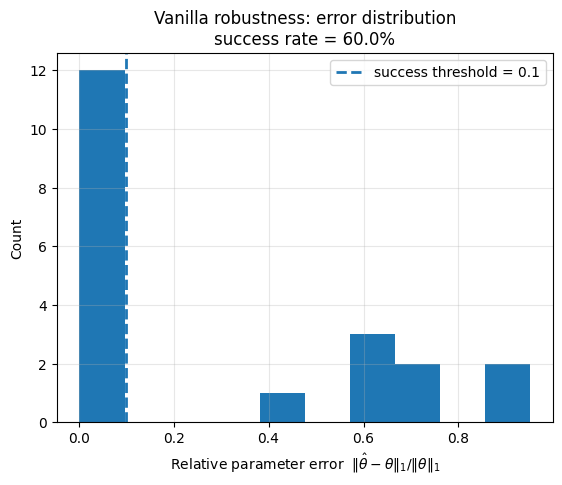

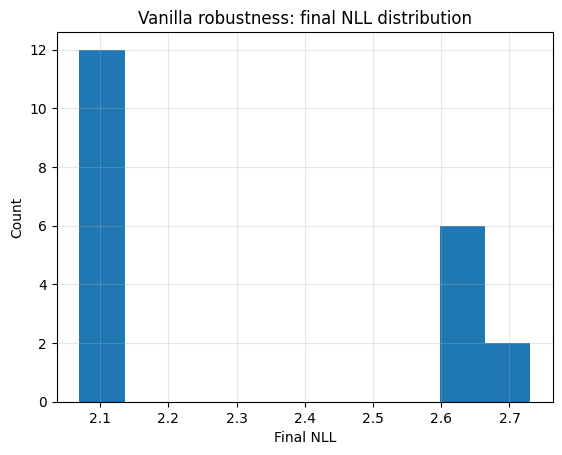

Success rate: 0.6
Errors (mean ± std): 0.2866498453999257 ± 0.3591042947898041


In [ ]:

def relative_param_error(theta_hat: np.ndarray, theta_true: np.ndarray, eps: float = 1e-12) -> float:
    """
    Error relativo tipo paper:
        ||theta_hat - theta_true||_1 / (||theta_true||_1 + eps)
    """
    num = np.linalg.norm(theta_hat - theta_true, ord=1)
    den = np.linalg.norm(theta_true, ord=1) + eps
    return float(num / den)

def robustness_study_vanilla(
    dataset: dict,
    n_runs: int = 20,
    init_low: float = -0.2,
    init_high: float = 1.2,
    success_threshold: float = 0.1,   # típico (paper usa 0.1)
    num_steps: int = 500,
    lr: float = 0.05,
    device: str = "cpu",
    patience_stop: int = 30,
    min_delta: float = 1e-5,
    seed: int = 0,
    verbose_each_run: bool = False,
):
    """
    Repite el entrenamiento n_runs veces con distintas inicializaciones.
    Devuelve errores finales, NLL finales, parámetros finales y success rate.
    """
    rng = np.random.default_rng(seed)

    errors = []
    final_nll = []
    final_params = []
    steps_used = []

    for r in range(n_runs):
        init_params = rng.uniform(init_low, init_high, size=5)

        hist = train_vanilla_model(
            dataset,
            num_steps=num_steps,
            lr=lr,
            device=device,
            init_params=init_params,
            patience_stop=patience_stop,
            min_delta=min_delta,
            verbose=verbose_each_run,
        )

        theta_true = hist["true"]
        theta_hat = hist["params"][-1]          # último valor aprendido
        nll_last = hist["loss"][-1]             # última NLL
        steps_last = len(hist["loss"])

        err = relative_param_error(theta_hat, theta_true)

        errors.append(err)
        final_nll.append(float(nll_last))
        final_params.append(theta_hat.copy())
        steps_used.append(steps_last)

        if not verbose_each_run:
            print(f"Run {r+1:02d}/{n_runs} | steps={steps_last:4d} | NLL={nll_last:.5f} | rel.err={err:.4f}")

    errors = np.array(errors)
    final_nll = np.array(final_nll)
    final_params = np.array(final_params)
    steps_used = np.array(steps_used)

    success = errors < success_threshold
    success_rate = float(np.mean(success))

    results = {
        "errors": errors,
        "final_nll": final_nll,
        "final_params": final_params,
        "steps_used": steps_used,
        "success": success,
        "success_threshold": success_threshold,
        "success_rate": success_rate,
    }
    return results

def plot_robustness_hist(results: dict, bins: int = 12, title_prefix: str = "Vanilla"):
    errors = results["errors"]
    thr = results["success_threshold"]
    success_rate = results["success_rate"]

    plt.figure()
    plt.hist(errors, bins=bins)
    plt.axvline(thr, linestyle="--", linewidth=2, label=f"success threshold = {thr}")
    plt.xlabel(r"Relative parameter error  $\|\hat\theta-\theta\|_1 / \|\theta\|_1$")
    plt.ylabel("Count")
    plt.title(f"{title_prefix} robustness: error distribution\nsuccess rate = {success_rate*100:.1f}%")
    plt.grid(alpha=0.3)
    plt.legend()
    plt.show()

    # (Opcional) histograma de NLL final
    plt.figure()
    plt.hist(results["final_nll"], bins=bins)
    plt.xlabel("Final NLL")
    plt.ylabel("Count")
    plt.title(f"{title_prefix} robustness: final NLL distribution")
    plt.grid(alpha=0.3)
    plt.show()

# ============================================================
# Example robustness study:
# ============================================================

rob = robustness_study_vanilla(
    dataset,
    n_runs=20,
    init_low=0.1,
    init_high=1,
    success_threshold=0.1,
    num_steps=500,
    lr=0.01,
    device="cpu",
    patience_stop=30,
    min_delta=1e-5,
    seed=123,
    verbose_each_run=False,   # pon True si quieres ver prints dentro de cada run
)


plot_robustness_hist(rob, bins=10, title_prefix="Vanilla")
print("Success rate:", rob["success_rate"])
print("Errors (mean ± std):", rob["errors"].mean(), "±", rob["errors"].std())

In [ ]:
# save data for later analysis
#time 23 min
with open("robustness_vanilla.pkl", "wb") as f:
    pickle.dump(rob, f)


Loaded robustness data keys: dict_keys(['errors', 'final_nll', 'final_params', 'steps_used', 'success', 'success_threshold', 'success_rate'])
Loaded success rate: 0.6
Loaded errors (mean ± std): 0.2866498453999257 ± 0.3591042947898041


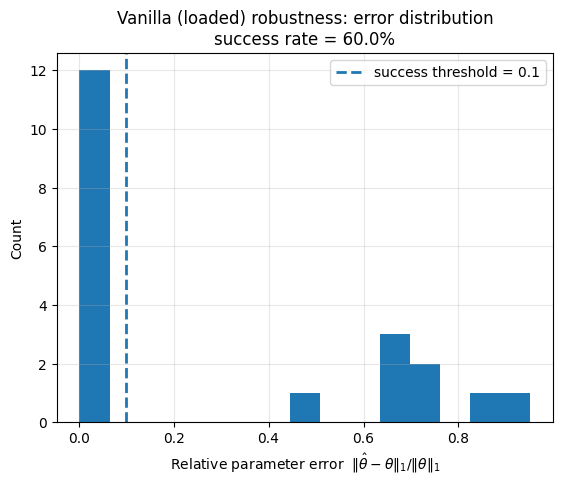

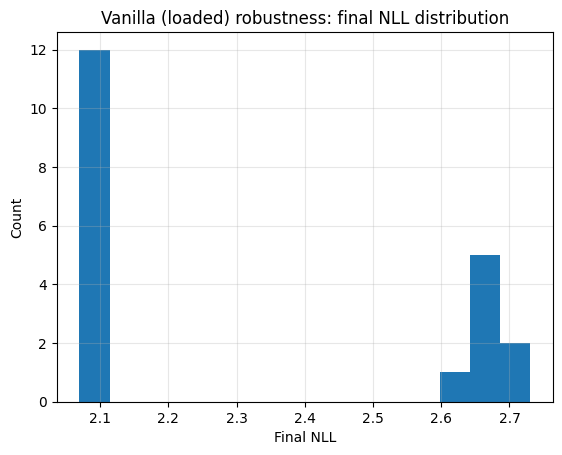

In [ ]:

with open("robustness_vanilla.pkl", "rb") as f:
    loaded_rob = pickle.load(f)
print("Loaded robustness data keys:", loaded_rob.keys())
print("Loaded success rate:", loaded_rob["success_rate"])
print("Loaded errors (mean ± std):", loaded_rob["errors"].mean(), "±", loaded_rob["errors"].std())
plot_robustness_hist(loaded_rob, bins=15, title_prefix="Vanilla (loaded)")

## Neural ODE

In [ ]:


# ============================================================
# CAMBIOS:
# 1) RK4: eliminada normalización dentro de rk4_step.
#    La normalización se aplica SOLO al guardar estados (integrate_ode_rk4).
# 2) Integración: añadimos m substeps por intervalo para mayor precisión.
# 3) CoeffNet: pasa de R^2 -> R^2 a R^5 -> R^5 (para [Jxx,Jyy,Jzz,hx,hz]).
# 4) Plot: grafica c_eff (parámetros efectivos usados en el Hamiltoniano).
# ============================================================

# ============================================================
# Neural ODE: RK4 integrator for Schrödinger equation
# dpsi/dt = -i H psi
# ============================================================
def rk4_step(psi, dt, H):
    # RK4 step WITHOUT renormalizing inside the integrator
    k1 = (-1j) * (H @ psi)
    k2 = (-1j) * (H @ (psi + 0.5 * dt * k1))
    k3 = (-1j) * (H @ (psi + 0.5 * dt * k2))
    k4 = (-1j) * (H @ (psi + dt * k3))
    psi_next = psi + (dt / 6.0) * (k1 + 2*k2 + 2*k3 + k4)
    return psi_next


def integrate_ode_rk4(psi0, times_torch, H, m=20):
    """
    Integrate from t=0 to each time in times_torch using RK4 with m substeps.
    Normalization is applied only when storing psi(t_k), not inside RK4.
    """
    states = []
    t_prev = 0.0
    psi = psi0

    for t in times_torch:
        t_target = float(t.item())
        dt_big = t_target - t_prev
        dt = dt_big / m

        for _ in range(m):
            psi = rk4_step(psi, dt, H)
            t_prev += dt

        # normalize once per observation time (numerical stability)
        psi = psi / torch.linalg.norm(psi)
        states.append(psi)

    return torch.stack(states, dim=0)  # (T, dim)

def integrate_ode_rk4_time_dependent(psi0, times_torch, c, net, n, device, dc_scale=0.2, m=20):
    states = []
    t_prev = torch.tensor(0.0, dtype=torch.float64, device=device)
    psi = psi0

    for t in times_torch:
        t_target = t.to(torch.float64)
        dt_big = t_target - t_prev
        dt = dt_big / m

        for _ in range(m):
            # c_eff(t_prev)
            dc = dc_scale * net(c, t_prev)
            c_eff = c + dc

            H = build_ansatz_hamiltonian_torch(
                n, c_eff.to(torch.complex128), device=device
            )

            psi = rk4_step(psi, float(dt.item()), H)
            t_prev = t_prev + dt

        psi = psi / torch.linalg.norm(psi)
        states.append(psi)

    return torch.stack(states, dim=0)
# ============================================================
# Neural map NN_phi on coefficients: R^5 -> R^5
# params = [Jxx, Jyy, Jzz, hx, hz]
# ============================================================
class CoeffNetT(nn.Module):
    def __init__(self, hidden=32, dim_params=5):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(dim_params + 1, hidden),
            nn.Tanh(),
            nn.Linear(hidden, hidden),
            nn.Tanh(),
            nn.Linear(hidden, dim_params),
        )

    def forward(self, c, t):
        # c: (5,), t: float tensor ()
        x = torch.cat([c, t.view(1)], dim=0)
        return self.net(x)


def plot_training_nde_eff(history: dict):

    loss = history["loss"]
    c_eff = history["c_eff"]
    true_vec = history["true"]
    names = history.get("names", [f"p{i}" for i in range(c_eff.shape[1])])

    # Loss
    plt.figure()
    plt.plot(np.arange(len(loss)), loss)
    plt.xlabel("Step")
    plt.ylabel("NLL")
    plt.title("Training loss (Neural ODE)")
    plt.grid(alpha=0.3)
    plt.show()

    # Params efectivos
    plt.figure()
    steps = np.arange(len(c_eff))
    for k in range(c_eff.shape[1]):
        plt.plot(steps, c_eff[:, k], label=rf"${names[k]}^{{eff}}$")
        plt.axhline(true_vec[k], linestyle="--", color=plt.gca().lines[-1].get_color(), alpha=0.7)

    plt.xlabel("Step")
    plt.ylabel("Parameter value")
    plt.title("Learned Hamiltonian parameters (effective)")
    plt.legend()
    plt.grid(alpha=0.3)
    plt.show()

def plot_training_nde_eff(history: dict):

torch.set_default_dtype(torch.float64)
    loss = history["loss"]
    c_eff = history["c_eff"]
    true_vec = history["true"]
    names = history.get("names", [f"p{i}" for i in range(c_eff.shape[1])])

    # Loss
    plt.figure()
    plt.plot(np.arange(len(loss)), loss)
    plt.xlabel("Step")
    plt.ylabel("NLL")
    plt.title("Training loss (Neural ODE)")
    plt.grid(alpha=0.3)
    plt.show()

    # Params efectivos
    plt.figure()
    steps = np.arange(len(c_eff))
    for k in range(c_eff.shape[1]):
        plt.plot(steps, c_eff[:, k], label=rf"${names[k]}^{{eff}}$")
        plt.axhline(true_vec[k], linestyle="--", color=plt.gca().lines[-1].get_color(), alpha=0.7)

    plt.xlabel("Step")
    plt.ylabel("Parameter value")
    plt.title("Learned Hamiltonian parameters (effective)")
    plt.legend()
    plt.grid(alpha=0.3)
    plt.show()

    


## Entrenamientos

[NDE(t)] Step    1/300 | Loss=2.528144 | Jxx_eff=0.1816 (true 0.1000) | Jyy_eff=0.2423 (true 0.2000) | Jzz_eff=0.9256 (true 0.7000) | hx_eff=0.1079 (true 0.3000) | hz_eff=0.7320 (true 1.0000)
[NDE(t)] Step    2/300 | Loss=2.473012 | Jxx_eff=0.1563 (true 0.1000) | Jyy_eff=0.2010 (true 0.2000) | Jzz_eff=0.9097 (true 0.7000) | hx_eff=0.1820 (true 0.3000) | hz_eff=0.7770 (true 1.0000)
[NDE(t)] Step    3/300 | Loss=2.454202 | Jxx_eff=0.1518 (true 0.1000) | Jyy_eff=0.1911 (true 0.2000) | Jzz_eff=0.8590 (true 0.7000) | hx_eff=0.2239 (true 0.3000) | hz_eff=0.7986 (true 1.0000)
[NDE(t)] Step    4/300 | Loss=2.423677 | Jxx_eff=0.1588 (true 0.1000) | Jyy_eff=0.1872 (true 0.2000) | Jzz_eff=0.8079 (true 0.7000) | hx_eff=0.2529 (true 0.3000) | hz_eff=0.8380 (true 1.0000)
[NDE(t)] Step    5/300 | Loss=2.359584 | Jxx_eff=0.1638 (true 0.1000) | Jyy_eff=0.1787 (true 0.2000) | Jzz_eff=0.7520 (true 0.7000) | hx_eff=0.2731 (true 0.3000) | hz_eff=0.8926 (true 1.0000)
[NDE(t)] Step    6/300 | Loss=2.249112 |

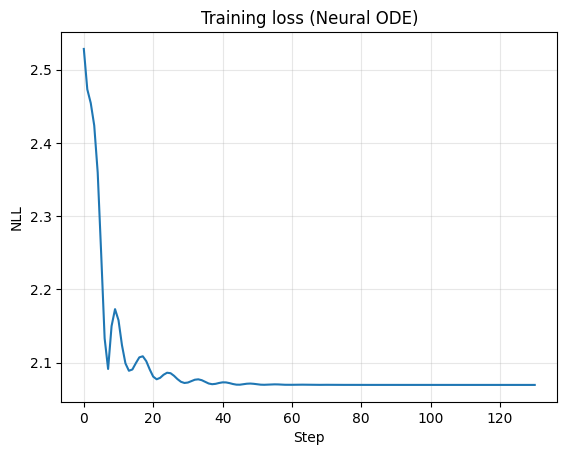

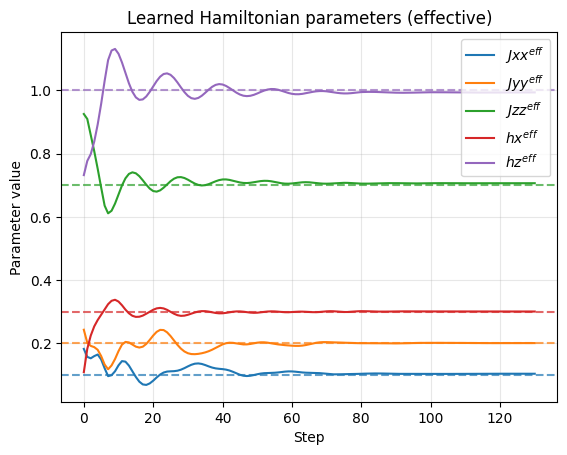

In [ ]:
# ============================================================
# PEGAR TAL CUAL (arreglado):
# - Usa CoeffNetT(c,t) correctamente
# - NO calcula dc/net(c) fuera (eso daba error y además no sirve con H(t))
# - Regularización evaluada en 3 tiempos (0, medio, final)
# - Guarda c_eff en t=0 para el plot (y opcionalmente en t=T)
# REQUIERE que tengas definidas:
#   - CoeffNetT (la red con forward(self, c, t))
#   - integrate_ode_rk4_time_dependent (la que construye H dentro del integrador)
#   - build_ansatz_hamiltonian_torch, build_rotation_operator, probs_in_measurement_basis
# ============================================================

def train_neural_ode_model(
    dataset: dict,
    num_steps: int = 300,
    lr: float = 5e-2,
    eps: float = 1e-12,
    device: str = "cpu",
    hidden: int = 32,
    dc_scale: float = 0.05,
    m: int = 20,
    regularization: float = 0.001,
    init: list = None,

    # early stopping
    patience_stop: int = 50,
    min_delta: float = 1e-5,
    everbose: bool = True,
):


    n = int(dataset["n"])
    times = torch.tensor(dataset["times"], dtype=torch.float64, device=device)  # (T,)
    pauli_obs = dataset["pauli_obs"]         # numpy (P,n)
    samples = dataset["samples"]             # numpy (S,T,P,shots)
    init_states = dataset["initial_states"]  # numpy (S,2^n) complex

    S, T, P, shots = samples.shape
    dim = 2**n

    # initial states to torch complex
    init_states_t = torch.tensor(init_states, dtype=torch.complex128, device=device)

    # precompute rotation matrices
    Urots = []
    for p in range(P):
        Urots.append(build_rotation_operator(pauli_obs[p], device=device))
    Urots = torch.stack(Urots, dim=0)  # (P, dim, dim)

    # ------------------------------------------------------------
    # Parámetros a aprender (5): [Jxx, Jyy, Jzz, hx, hz]
    # ------------------------------------------------------------
    dim_params = 5
    if init is None:
        init = [0.5] * dim_params
    assert len(init) == dim_params, f"`init` debe tener longitud {dim_params}"

    c = nn.Parameter(torch.tensor(init, dtype=torch.float64, device=device))

    # Red con tiempo: forward(c, t) -> R^5
    net = CoeffNetT(hidden=hidden, dim_params=dim_params).to(device)

    opt = torch.optim.Adam(list(net.parameters()) + [c], lr=lr)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        opt, mode="min", factor=0.5, patience=20, min_lr=1e-4
    )

    # True parameters (desde dataset)
    true_dict = dataset["true_params"]
    param_names = ["Jxx", "Jyy", "Jzz", "hx", "hz"]
    true_vec = np.array([float(true_dict[k]) for k in param_names], dtype=np.float64)

    loss_hist = []
    c_hist = []
    dc_hist = []
    c_eff_hist = []

    # early stopping state
    best_loss = float("inf")
    steps_since_improve = 0

    # tiempos para regularización y logging
    t0 = torch.tensor(0.0, dtype=torch.float64, device=device)
    tmid = times[len(times)//2]
    tT = times[-1]

    for step in range(num_steps):
        opt.zero_grad()

        total_logp = torch.tensor(0.0, dtype=torch.float64, device=device)
        count = 0

        for s in range(S):
            psi0 = init_states_t[s]  # (dim,)
            psi_ts = integrate_ode_rk4_time_dependent(
                psi0, times, c, net, n, device=device, dc_scale=dc_scale, m=m
            )  # (T, dim)

            for ti in range(T):
                psi_t = psi_ts[ti]
                for p in range(P):
                    probs = probs_in_measurement_basis(psi_t, Urots[p])
                    idx = torch.tensor(samples[s, ti, p], dtype=torch.long, device=device)
                    p_samp = probs[idx]
                    total_logp = total_logp + torch.sum(torch.log(p_samp + eps))
                    count += shots

        nll = -total_logp / count

        # Regularización: penaliza tamaño de dc en varios tiempos
        dc0 = dc_scale * net(c, t0)
        dcm = dc_scale * net(c, tmid)
        dcT = dc_scale * net(c, tT)
        reg = regularization * (dc0.pow(2).sum() + dcm.pow(2).sum() + dcT.pow(2).sum()) / 3.0

        loss = nll + reg
        loss.backward()
        opt.step()

        loss_val = float(loss.detach().cpu().item())
        loss_hist.append(loss_val)

        # logging/plots: guardamos c, dc(t=0) y c_eff(t=0)
        with torch.no_grad():
            dc_log = (dc_scale * net(c, t0)).detach()
            c_eff_log = (c + dc_log).detach()

        c_hist.append(c.detach().cpu().numpy().copy())
        dc_hist.append(dc_log.cpu().numpy().copy())
        c_eff_hist.append(c_eff_log.cpu().numpy().copy())

        cur_eff = c_eff_hist[-1]
        if everbose:
            print(
                f"[NDE(t)] Step {step+1:4d}/{num_steps} | Loss={loss_val:.6f} | "
                f"Jxx_eff={cur_eff[0]:.4f} (true {true_vec[0]:.4f}) | "
                f"Jyy_eff={cur_eff[1]:.4f} (true {true_vec[1]:.4f}) | "
                f"Jzz_eff={cur_eff[2]:.4f} (true {true_vec[2]:.4f}) | "
                f"hx_eff={cur_eff[3]:.4f} (true {true_vec[3]:.4f}) | "
                f"hz_eff={cur_eff[4]:.4f} (true {true_vec[4]:.4f})"
            )

        scheduler.step(loss.detach())

        # Early stopping
        if loss_val < best_loss - min_delta:
            best_loss = loss_val
            steps_since_improve = 0
        else:
            steps_since_improve += 1

        if steps_since_improve >= patience_stop:
            print(
                f"[EarlyStopping] Parando en step {step+1} porque la loss no mejora "
                f"(min_delta={min_delta}) en {patience_stop} iteraciones. Best={best_loss:.6f}"
            )
            break

    history = {
        "loss": np.array(loss_hist),
        "c": np.array(c_hist),
        "dc": np.array(dc_hist),
        "c_eff": np.array(c_eff_hist),
        "true": true_vec,
        "names": param_names,
    }
    return history


# ==========================
# EJEMPLO DE EJECUCIÓN
# ==========================
init_params = np.random.uniform(0, 1, size=5)


history_nde_modificado = train_neural_ode_model(
    dataset,
    num_steps=300,
    lr=0.01,
    hidden=32,
    dc_scale=0.2,
    m=30, 
    regularization=0.001,
    init=init_params,
    patience_stop=50,
    min_delta=1e-5
)

plot_training_nde_eff(history_nde_modificado)

In [11]:
print(relative_param_error(history_nde_modificado["c_eff"][-1], history_nde_modificado["true"]))

0.006701813274897073


## robustness

[NDE(t)] Step    1/500 | Loss=3.282843 | Jxx_eff=0.7153 (true 0.1000) | Jyy_eff=0.1162 (true 0.2000) | Jzz_eff=0.3453 (true 0.7000) | hx_eff=0.2783 (true 0.3000) | hz_eff=0.3024 (true 1.0000)
[NDE(t)] Step    2/500 | Loss=3.052463 | Jxx_eff=0.6918 (true 0.1000) | Jyy_eff=0.0848 (true 0.2000) | Jzz_eff=0.3910 (true 0.7000) | hx_eff=0.2643 (true 0.3000) | hz_eff=0.3488 (true 1.0000)
[NDE(t)] Step    3/500 | Loss=2.946588 | Jxx_eff=0.6627 (true 0.1000) | Jyy_eff=0.0649 (true 0.2000) | Jzz_eff=0.4345 (true 0.7000) | hx_eff=0.2400 (true 0.3000) | hz_eff=0.3964 (true 1.0000)
[NDE(t)] Step    4/500 | Loss=2.821721 | Jxx_eff=0.6320 (true 0.1000) | Jyy_eff=0.0512 (true 0.2000) | Jzz_eff=0.4830 (true 0.7000) | hx_eff=0.2077 (true 0.3000) | hz_eff=0.4487 (true 1.0000)
[NDE(t)] Step    5/500 | Loss=2.699556 | Jxx_eff=0.5951 (true 0.1000) | Jyy_eff=0.0457 (true 0.2000) | Jzz_eff=0.5317 (true 0.7000) | hx_eff=0.1671 (true 0.3000) | hz_eff=0.5033 (true 1.0000)
[NDE(t)] Step    6/500 | Loss=2.633671 |

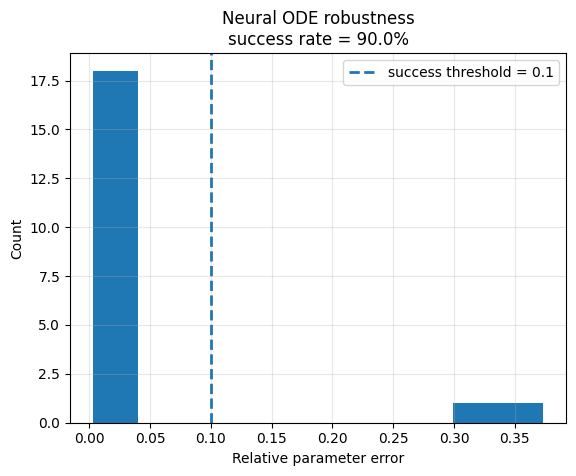

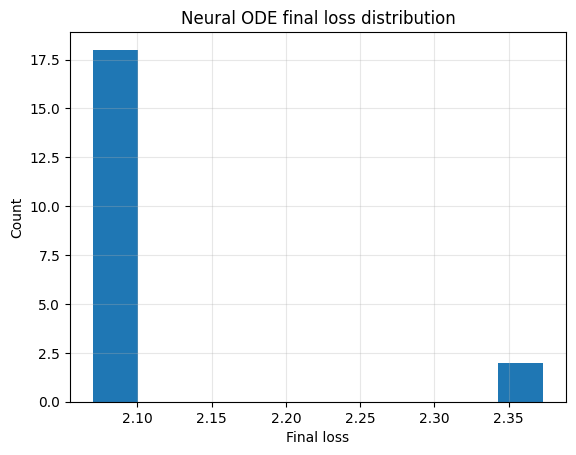

NDE Success rate: 0.9
Errors (mean ± std): 0.04371054508428452 ± 0.10190063130550145


In [12]:
def robustness_study_nde(
    dataset: dict,
    n_runs: int = 20,
    init_low: float = 0.0,
    init_high: float = 1.0,
    success_threshold: float = 0.1,
    num_steps: int = 500,
    lr: float = 1e-2,
    hidden: int = 32,
    dc_scale: float = 0.01,
    m: int = 20,
    regularization: float = 0.001,
    patience_stop: int = 50,
    min_delta: float = 1e-5,
    device: str = "cpu",
    seed: int = 0,
    verbose_each_run: bool = False,
):
    rng = np.random.default_rng(seed)

    errors = []
    final_loss = []
    final_params = []
    steps_used = []

    for r in range(n_runs):
        init_params = rng.uniform(init_low, init_high, size=5)

        hist = train_neural_ode_model(
            dataset,
            num_steps=num_steps,
            lr=lr,
            hidden=hidden,
            dc_scale=dc_scale,
            m=m,
            regularization=regularization,
            init=init_params,
            patience_stop=patience_stop,
            min_delta=min_delta,
            device=device,
            everbose=verbose_each_run,
        )

        theta_true = hist["true"]
        theta_hat = hist["c_eff"][-1]  # <-- IMPORTANTE: usar c_eff
        loss_last = hist["loss"][-1]
        steps_last = len(hist["loss"])

        err = relative_param_error(theta_hat, theta_true)

        errors.append(err)
        final_loss.append(loss_last)
        final_params.append(theta_hat.copy())
        steps_used.append(steps_last)


        print(f"[NDE] Run {r+1:02d}/{n_runs} | steps={steps_last:4d} | loss={loss_last:.5f} | rel.err={err:.4f}")

    errors = np.array(errors)
    final_loss = np.array(final_loss)
    final_params = np.array(final_params)
    steps_used = np.array(steps_used)

    success = errors < success_threshold
    success_rate = float(np.mean(success))

    results = {
        "errors": errors,
        "final_loss": final_loss,
        "final_params": final_params,
        "steps_used": steps_used,
        "success": success,
        "success_threshold": success_threshold,
        "success_rate": success_rate,
    }
    return results


def plot_robustness_hist(results: dict, bins: int = 12, title_prefix: str = "Model"):
    errors = results["errors"]
    thr = results["success_threshold"]
    success_rate = results["success_rate"]

    # Histograma error relativo
    plt.figure()
    plt.hist(errors, bins=bins)
    plt.axvline(thr, linestyle="--", linewidth=2, label=f"success threshold = {thr}")
    plt.xlabel(r"Relative parameter error")
    plt.ylabel("Count")
    plt.title(f"{title_prefix} robustness\nsuccess rate = {success_rate*100:.1f}%")
    plt.grid(alpha=0.3)
    plt.legend()
    plt.show()

    # Histograma loss final (compatible con ambos modelos)
    key = "final_nll" if "final_nll" in results else "final_loss"

    plt.figure()
    plt.hist(results[key], bins=bins)
    plt.xlabel("Final loss")
    plt.ylabel("Count")
    plt.title(f"{title_prefix} final loss distribution")
    plt.grid(alpha=0.3)
    plt.show()

rob_nde = robustness_study_nde(
    dataset,
    n_runs=20,
    init_low=0.1,
    init_high=1,
    lr=0.01,
    hidden=32,
    dc_scale=0.2,
    m=30,
    regularization=0.001,
    patience_stop=50,
    min_delta=1e-5,
    success_threshold=0.1,
    seed=123,
    verbose_each_run=True,
)

plot_robustness_hist(rob_nde, bins=10, title_prefix="Neural ODE")

print("NDE Success rate:", rob_nde["success_rate"])
print("Errors (mean ± std):", rob_nde["errors"].mean(), "±", rob_nde["errors"].std())

In [ ]:
# time = 400 min
# save data for later analysis (opcional)
'''with open("robustness_nde.pkl", "wb") as f:
    pickle.dump(rob_nde, f)'''

Loaded NDE robustness data keys: dict_keys(['errors', 'final_loss', 'final_params', 'steps_used', 'success', 'success_threshold', 'success_rate'])
Loaded NDE success rate: 0.9
Loaded NDE errors (mean ± std): 0.04371054508428452 ± 0.10190063130550145


In [ ]:

def plot_robustness_hist(results: dict, bins: int = 12, title_prefix: str = "Model"):
    errors = results["errors"]
    thr = results["success_threshold"]
    success_rate = results["success_rate"]

    # Histograma error relativo
    plt.figure()
    plt.hist(errors, bins=bins)
    plt.axvline(thr, linestyle="--", linewidth=2, label=f"success threshold = {thr}")
    plt.xlabel(r"Relative parameter error")
    plt.ylabel("Count")
    plt.title(f"{title_prefix} robustness\nsuccess rate = {success_rate*100:.1f}%")
    plt.grid(alpha=0.3)
    plt.legend()
    plt.show()

    # Histograma loss final (compatible con ambos modelos)
    key = "final_nll" if "final_nll" in results else "final_loss"

    plt.figure()
    plt.hist(results[key], bins=bins)
    plt.xlabel("Final loss")
    plt.ylabel("Count")
    plt.title(f"{title_prefix} final loss distribution")
    plt.grid(alpha=0.3)
    plt.show()

Loaded NDE robustness data keys: dict_keys(['errors', 'final_loss', 'final_params', 'steps_used', 'success', 'success_threshold', 'success_rate'])
Loaded NDE success rate: 0.9
Loaded NDE errors (mean ± std): 0.04371054508428452 ± 0.10190063130550145


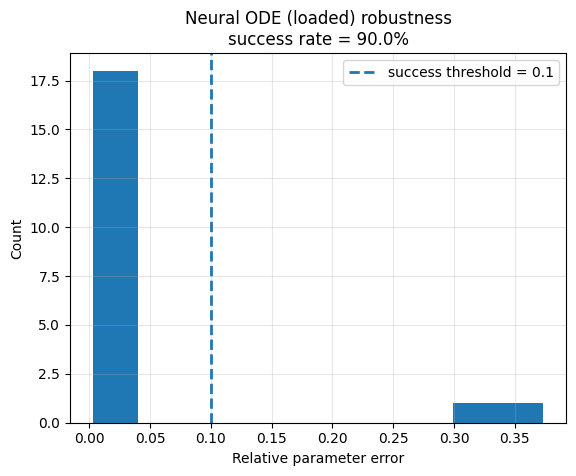

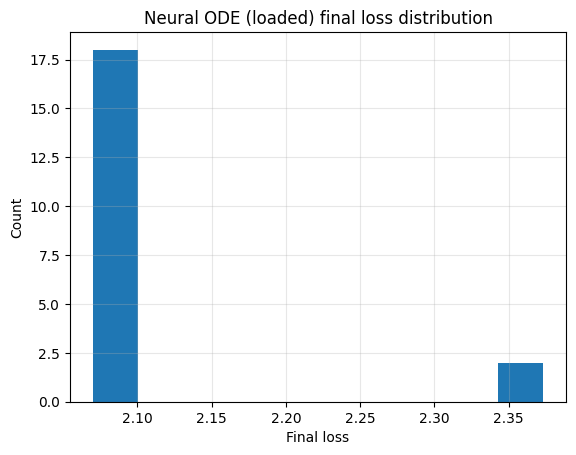

In [ ]:

# load data to check it worked
with open("robustness_nde.pkl", "rb") as f:
    loaded_rob_nde = pickle.load(f)
print("Loaded NDE robustness data keys:", loaded_rob_nde.keys())
print("Loaded NDE success rate:", loaded_rob_nde["success_rate"])
print("Loaded NDE errors (mean ± std):", loaded_rob_nde["errors"].mean(), "±", loaded_rob_nde["errors"].std())

plot_robustness_hist(loaded_rob_nde, bins=10, title_prefix="Neural ODE (loaded)")